<a href="https://colab.research.google.com/github/Ogunfool/Ogunfool/blob/main/RUL_Estimation_NASA__Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do the python implementation of the similarity based RUL Estimation on MATLAB.

Import necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 

# Load and Plot Initial Data - Exploratory Data Analysis

While some people might argue that the more the features the better, some features might be redundant and have negative impact on the degradation data analysis. For the MATLAB example, feature extraction was conducted (I might decide not to do manual feature extraction if I use LSTM for this dataset).

Helper Functions


In [ ]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)

In [ ]:
# Checkpoints - List , npz and npy files
# npz is a combination of two or more npy files
def checkpoints_z(filename, data_a, data_b, checkpoint_data):
  np.savez(filename, data_a=data_a, data_b=data_b, data=checkpoint_data)
  checkpoint_variable = np.load(filename + '.npz') #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# np.save() - Saves a single array in a binary numpy format
def checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data)
  checkpoint_variable = np.load(filename + '.npy') #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# List Checkpoint
def list_checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data, allow_pickle=True)
  checkpoint_variable = np.load(filename + '.npy', allow_pickle=True) #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# CSV Checkpoint
def checkpoints_csv(filename, checkpoint_data, data_type, col_names, fmt='%d', delimiter=','):
  if data_type == 'pandas':
    checkpoint_data.to_csv()
    checkpoint_variable = pd.read_csv(filename + '.csv',delim_whitespace=True,names=col_names)
  else:
    np.savetxt(filename+'.csv', checkpoint_data, fmt=fmt, delimiter=delimiter)
    checkpoint_variable = np.load(filename + '.csv', delimiter=delimiter) #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

In [ ]:
# Plots
# Line Plot Function
def plot_func(sensor_header, header_names, data_list):
  for sensor_n in sensor_header:
    for d_ind in range(10):
      plt.plot(data_list[d_ind][:,header_names.index(sensor_n)], label = 'ensemble-'+str(d_ind))
      plt.legend(loc='upper right')
      plt.title(sensor_n)
    plt.show()

# Side-by-side Plot Function: For dataframe (Try to combine both later)
def cycle_plot_func(sensor_header, data, n_samp = 500):
  for sensor_n in sensor_header:
    data[sensor_n][:n_samp].plot(c='teal')
    for m in [148,416,621,855,1008]:
      plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
    plt.title(sensor_n)
    plt.show()

# Side-by-side Plot Function: For array
def cycle_plot_func_a(data, n_samp):
  for n in range(data.shape[1]):
    plt.plot(data[:n_samp,n],c='teal')
    for m in [148,416,621,855,1008]:
      plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
    plt.title('sensor'+str(n+1))
    plt.show()

Load Data.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_FD002.txt to train_FD002 (2).txt


In [ ]:
# Create headers
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


In [ ]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv('/content/train_FD002.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          34.9983           0.8400            100.0   
1        1           2          41.9982           0.8408            100.0   
2        1           3          24.9988           0.6218             60.0   
3        1           4          42.0077           0.8416            100.0   
4        1           5          25.0005           0.6203             60.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    449.44    555.32   1358.61   1137.23      5.48  ...     183.06   
1    445.00    549.90   1353.22   1125.78      3.91  ...     130.42   
2    462.54    537.31   1256.76   1047.45      7.05  ...     164.22   
3    445.00    549.51   1354.03   1126.38      3.91  ...     130.72   
4    462.54    537.07   1257.71   1047.93      7.05  ...     164.31   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2387.72    8048.56     9.3461       0.02        334       2223   
1    2387.66    8072.30     9.3774       0.02        330       2212   
2    2028.03    7864.87    10.8941       0.02        309       1915   
3    2387.61    8068.66     9.3528       0.02        329       2212   
4    2028.00    7861.23    10.8963       0.02        309       1915   

   sensor_19  sensor_20  sensor_21  
0     100.00      14.73     8.8071  
1     100.00      10.41     6.2665  
2      84.93      14.08     8.6723  
3     100.00      10.59     6.4701  
4      84.93      14.13     8.5286  

[5 rows x 26 columns]

In [ ]:
raw_train_df.info()

Data Reloading Essentials : You can always decide to reload the train_data again, it doesn't really matter, I think what matters is the checkpoint, saving and loading the data back as csv read into pandas dataframe and numpy array.

In [ ]:
# # Load these datasets
# # data_list = np.load('/content/data-list.npy', allow_pickle=True)
# normalized_data_list = np.load('/content/normalized-data-list.npy', allow_pickle=True)
# normalized_unwrap_train_data = np.load('/content/normalized-unwrap-train-data.npy')
# normalized_unwrap_train_fdata = np.load('/content/normalized-unwrap-train-fdata.npy')
# best_eight=np.load('/content/best-eight.npy')

In [ ]:
# # Necessary parameters
# n_samples = 10
# header_names = list(raw_train_df.columns)
# sensor_header = list(header_names[-21:])

2D - 3D Data.
Because the 2D data dimensions are not the same, a ragged nested sequence is created instead so I use a list of arrays instead.

In [ ]:
# Something about np.where - It returns an array of the same shape as the condition
vals = raw_train_df.values
data_list = []  # List of arrays
for i in np.unique(raw_train_df['unit_id'].values):
  ind = np.where(raw_train_df['unit_id'].values == i)
  data_list.append(vals[ind])

In [ ]:
len(data_list)

260

In [ ]:
data_list[3][:,3].shape

(235,)

In [ ]:
checkpoint_data_list = list_checkpoints('data-list',data_list)

Plot.

In [ ]:
n_samples = 10
header_names = list(raw_train_df.columns)
sensor_header = list(header_names[-21:])

In [ ]:
len(header_names)

26

In [ ]:
sensor_header 

In [ ]:
header_names.index('sensor_3')

7

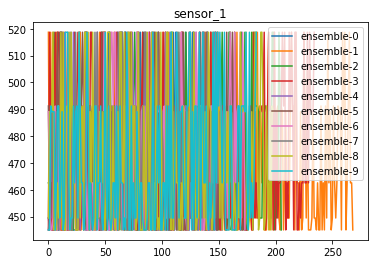

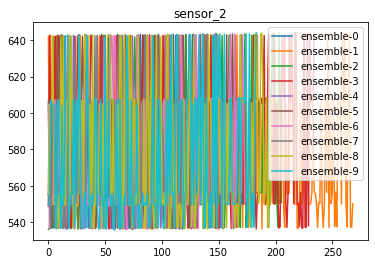

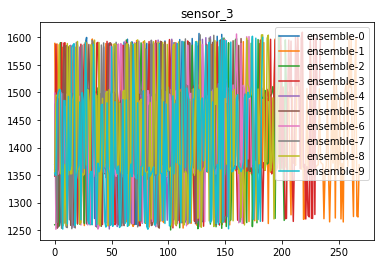

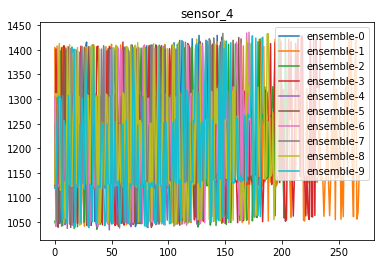

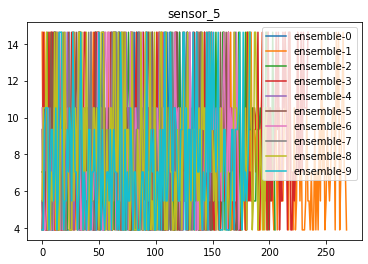

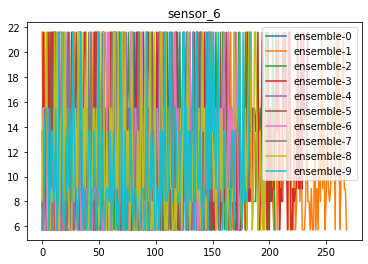

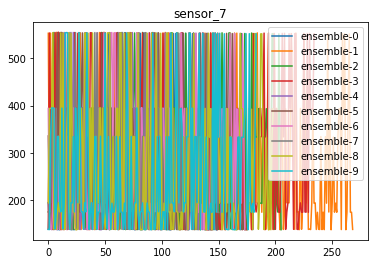

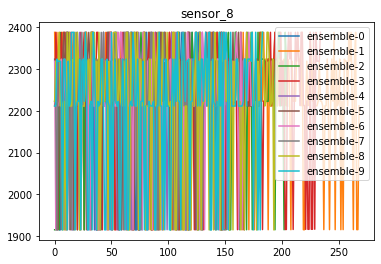

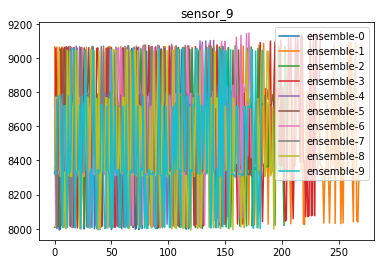

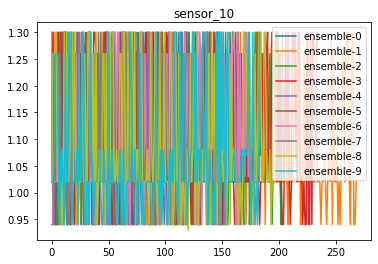

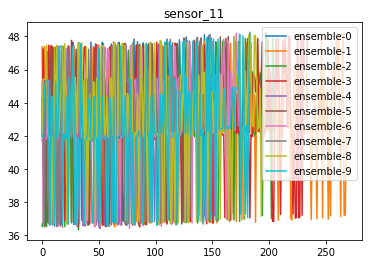

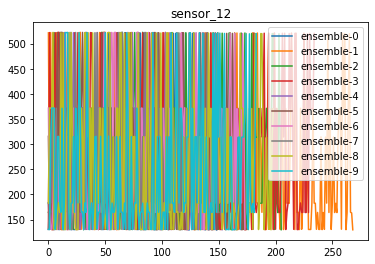

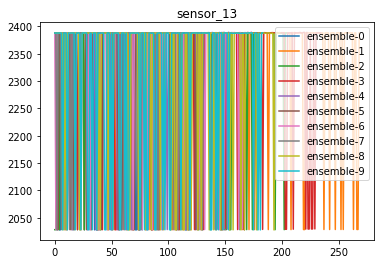

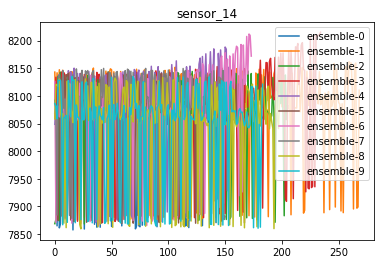

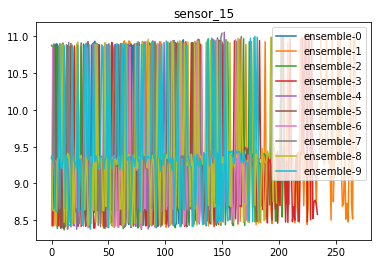

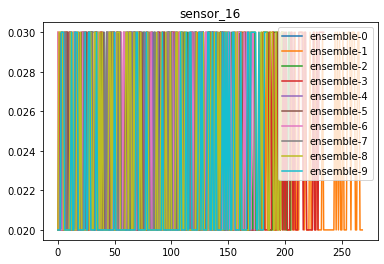

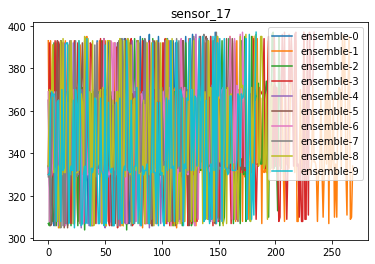

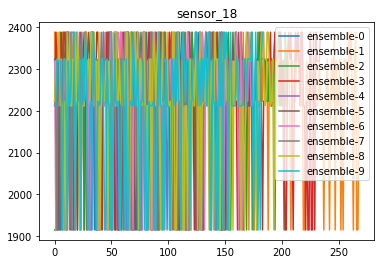

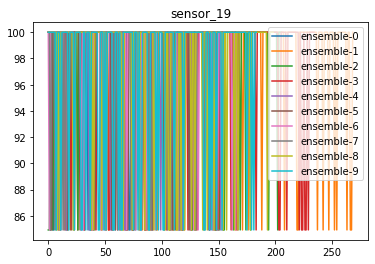

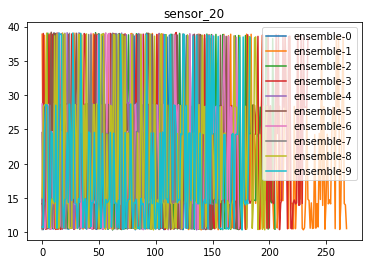

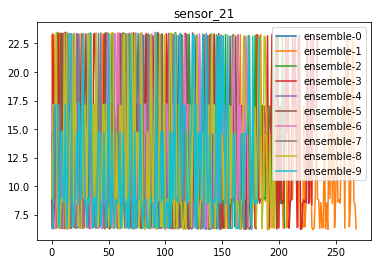

In [ ]:
plot_func(sensor_header, header_names, data_list)

Cycle plot

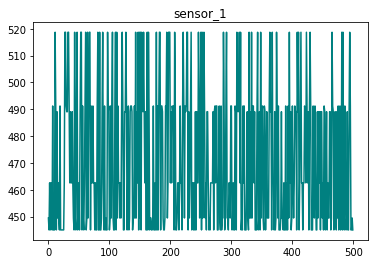

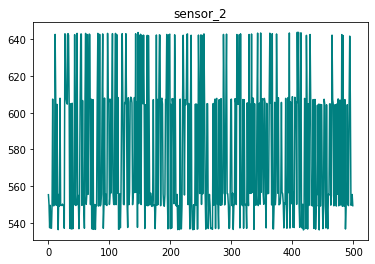

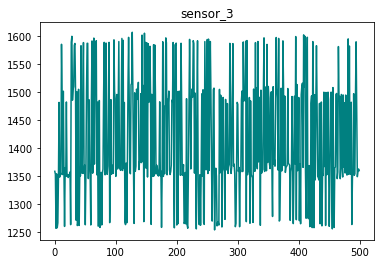

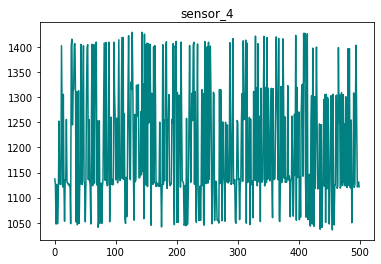

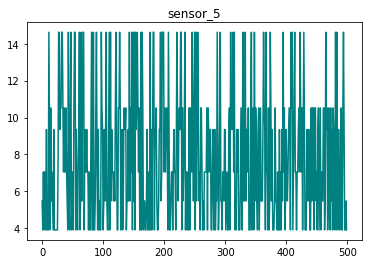

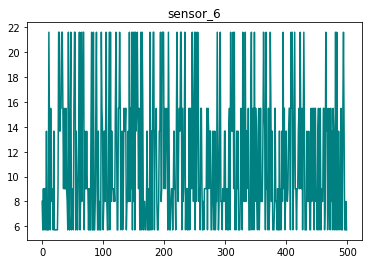

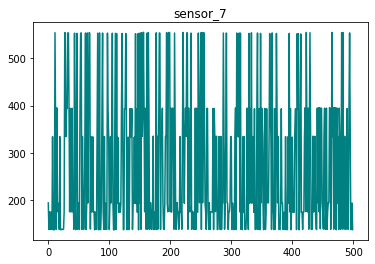

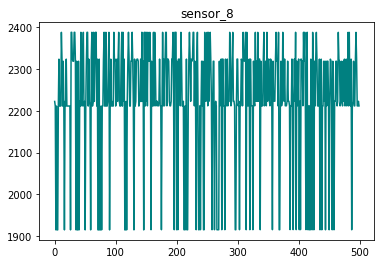

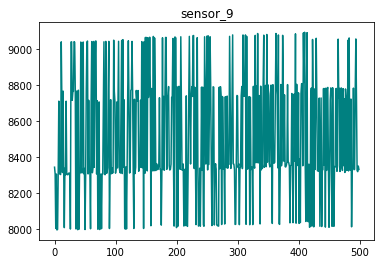

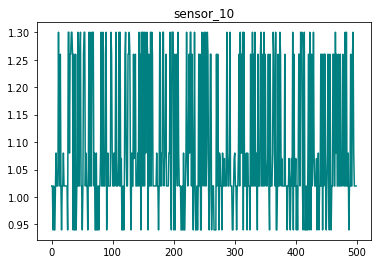

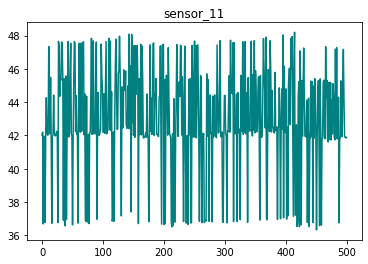

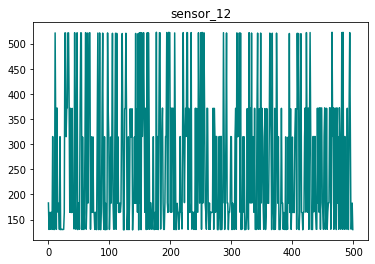

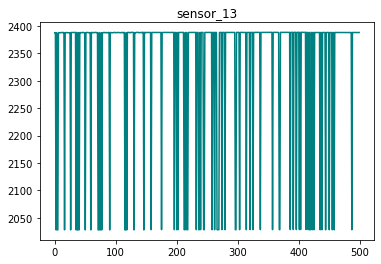

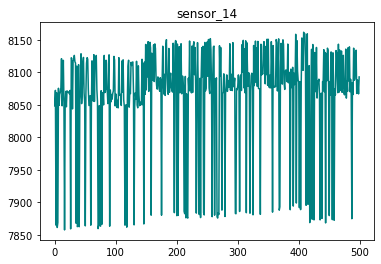

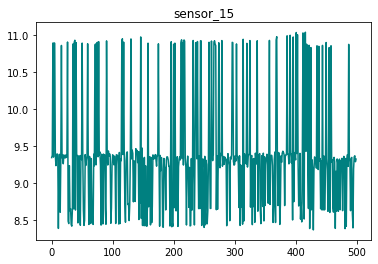

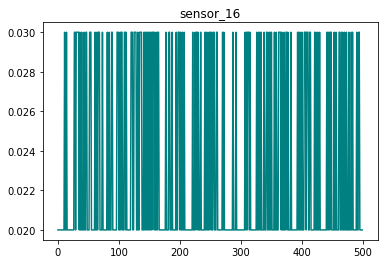

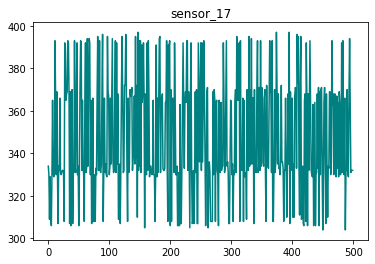

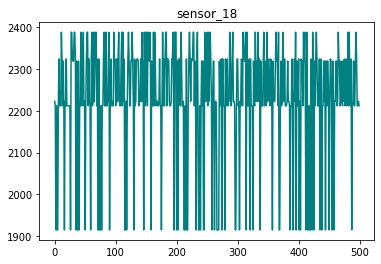

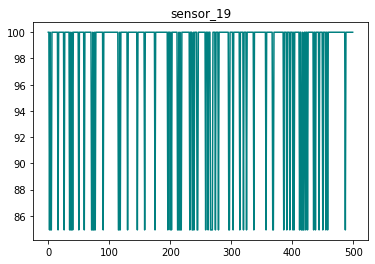

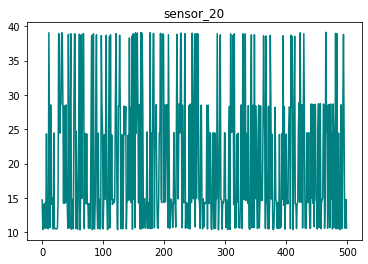

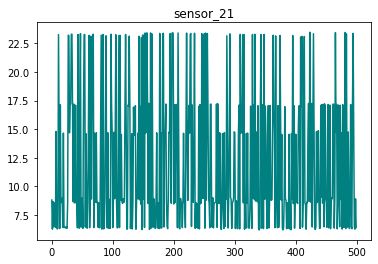

In [ ]:
cycle_plot_func(sensor_header=sensor_header, data = raw_train_df)

Summary Statistics

In [ ]:
stats = raw_train_df.describe()
raw_train_df.describe()

unit_id    time_cycle  op_conditions_1  op_conditions_2  \
count  53759.000000  53759.000000     53759.000000     53759.000000   
mean     131.082981    109.154746        23.998407         0.572056   
std       74.463862     69.180569        14.747376         0.310016   
min        1.000000      1.000000         0.000000         0.000000   
25%       68.000000     52.000000        10.004600         0.250700   
50%      131.000000    104.000000        25.001300         0.700000   
75%      195.000000    157.000000        41.998000         0.840000   
max      260.000000    378.000000        42.008000         0.842000   

       op_conditions_3      sensor_1      sensor_2      sensor_3  \
count     53759.000000  53759.000000  53759.000000  53759.000000   
mean         94.046020    472.910207    579.672399   1419.971013   
std          14.237735     26.389707     37.289399    105.946341   
min          60.000000    445.000000    535.530000   1243.730000   
25%         100.000000    445.000000    549.570000   1352.760000   
50%         100.000000    462.540000    555.980000   1369.180000   
75%         100.000000    491.190000    607.340000   1499.370000   
max         100.000000    518.670000    644.520000   1612.880000   

           sensor_4      sensor_5  ...     sensor_12     sensor_13  \
count  53759.000000  53759.000000  ...  53759.000000  53759.000000   
mean    1205.442024      8.031986  ...    266.069034   2334.557253   
std      119.123428      3.613839  ...    137.659507    128.068271   
min     1023.770000      3.910000  ...    129.120000   2027.610000   
25%     1123.655000      3.910000  ...    131.520000   2387.900000   
50%     1138.890000      7.050000  ...    183.200000   2388.080000   
75%     1306.850000     10.520000  ...    371.260000   2388.170000   
max     1439.230000     14.620000  ...    523.370000   2390.480000   

          sensor_14     sensor_15     sensor_16     sensor_17     sensor_18  \
count  53759.000000  53759.000000  53759.000000  53759.000000  53759.000000   
mean    8066.597682      9.329654      0.023326    348.309511   2228.806358   
std       84.837950      0.749335      0.004711     27.754515    145.327980   
min     7848.360000      8.335700      0.020000    303.000000   1915.000000   
25%     8062.140000      8.677800      0.020000    331.000000   2212.000000   
50%     8082.540000      9.310900      0.020000    335.000000   2223.000000   
75%     8127.195000      9.386900      0.030000    369.000000   2324.000000   
max     8268.500000     11.066900      0.030000    399.000000   2388.000000   

          sensor_19     sensor_20     sensor_21  
count  53759.000000  53759.000000  53759.000000  
mean      97.756838     20.789296     12.473423  
std        5.364067      9.869331      5.921615  
min       84.930000     10.180000      6.010500  
25%      100.000000     10.910000      6.546300  
50%      100.000000     14.880000      8.929200  
75%      100.000000     28.470000     17.083200  
max      100.000000     39.340000     23.590100  

[8 rows x 26 columns]

In [ ]:
stats_df = pd.DataFrame(stats, columns=all_col)

In [ ]:
# df.std() method
# This show a very high variance in the initial wear rates which makes this data harder to analyse
stats_df.loc['min'][-21:].std()

2330.8943654218615

In [ ]:
# df.min() method
raw_train_df['sensor_1'].min()

445.0

Split 3D Data to train and validation set.

*   Note: To avoid data leakage/spillage, I seperated the validation set from the train set before doing the cluster/working regimen normalization only on the train set (More like normalize only the first 200 machines/samples).




In [ ]:
wrap_train_data = data_list[:200]
wrap_val_data = data_list[200:]

In [ ]:
# Size of unwrapped val and train set
unwrap_sums = 0
for unwraps in wrap_val_data:
  unwrap_sums += unwraps.shape[0]
unwrap_val_lenght = unwrap_sums
unwrap_train_lenght =  len(raw_train_df) - unwrap_val_lenght

In [ ]:
unwrap_val_lenght

12303

In [ ]:
unwrap_train_data = raw_train_df.values[:unwrap_train_lenght]
unwrap_val_data = raw_train_df.values[unwrap_train_lenght:]

In [ ]:
unwrap_val_data.shape[0]

12303

In [ ]:
print(len(unwrap_train_data), len(unwrap_val_data))
print(len(wrap_train_data), len(wrap_val_data))

41456 12303
200 60


In [ ]:
wrap_val_data[1].shape

(197, 26)

In [ ]:
unwrap_train_data

array([[  1.  ,   1.  ,  35.  , ..., 100.  ,  14.73,   8.81],
       [  1.  ,   2.  ,  42.  , ..., 100.  ,  10.41,   6.27],
       [  1.  ,   3.  ,  25.  , ...,  84.93,  14.08,   8.67],
       ...,
       [200.  , 225.  ,  10.01, ..., 100.  ,  28.15,  16.88],
       [200.  , 226.  ,  20.01, ..., 100.  ,  24.23,  14.65],
       [200.  , 227.  ,  42.  , ..., 100.  ,  10.55,   6.22]])

In [ ]:
np.unique(unwrap_train_data[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
unwrap_val_data

array([[201.  ,   1.  ,  25.  , ...,  84.93,  14.44,   8.6 ],
       [201.  ,   2.  ,  42.  , ..., 100.  ,  10.69,   6.36],
       [201.  ,   3.  ,  42.  , ..., 100.  ,  10.7 ,   6.28],
       ...,
       [260.  , 314.  ,  25.  , ...,  84.93,  14.19,   8.55],
       [260.  , 315.  ,  25.  , ...,  84.93,  14.05,   8.37],
       [260.  , 316.  ,  35.  , ..., 100.  ,  14.75,   8.84]])

In [ ]:
np.unique(unwrap_val_data[:,0])

array([201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230.,
       231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.])

# Working Regimen Section

In [ ]:
# K-Means: Find Clusters and Find mean & std of clusters (Put in a dataframe)
# Stack/Unwrap data back to have a full train data cycle - raw_train_df_normalized

# Seperate the Operating conditions columns
op_condts_index = [2,3,4]
op_condts_data = unwrap_train_data[:,op_condts_index]
print(op_condts_data.shape)

(41456, 3)


In [ ]:
np.unique(op_condts_data[:,2])

array([ 60., 100.])

In [ ]:
# Use K-means to find clusters
# Run the Kmeans algorithm
kmeans = KMeans(n_clusters=6) # Greedy k-means is used when the n_clusters is not specified, it enables faster convergence
kmeans.fit(op_condts_data)
train_cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
# It is amazing that we got the same centroids with sklearn as we will with MATLAB
centroids

array([[ 42.  ,   0.84, 100.  ],
       [ 10.  ,   0.25, 100.  ],
       [ 25.  ,   0.62,  60.  ],
       [ 20.  ,   0.7 , 100.  ],
       [  0.  ,   0.  , 100.  ],
       [ 35.  ,   0.84, 100.  ]])

In [ ]:
train_cluster_labels.size

41456

In [ ]:
# Let's predict the closest cluster each sample in the validation set belongs to
val_cluster_labels = kmeans.predict(unwrap_val_data[:,op_condts_index])
print(val_cluster_labels.shape)

(12303,)


In [ ]:
val_cluster_labels

array([2, 0, 0, ..., 2, 2, 5], dtype=int32)

In [ ]:
# Working Regimen Helper Functions
# Cluster parameters function
no_clusters=6
def parameters_form(no_clusters, data, cluster_labels):
  parameters_mean_list = []
  parameters_std_list = []
  for label in range(no_clusters):
    cluster = data[cluster_labels == label]
    meaan = np.mean(cluster, axis = 0)
    stdd = np.std(cluster, axis = 0)
    parameters_mean_list.append(meaan)
    parameters_std_list.append(stdd)
  print(len(parameters_mean_list), len(parameters_std_list))
  return parameters_mean_list, parameters_std_list

# Normalize function
def normalize(X,mean,std):
  return (X - mean) / std

# Normalized unwrap data function
def normalize_regime(temp_data, cluster_labels, parameters_mean_list, parameters_std_list):
  # New Normalized with clusters dataset before split
  normalized_unwrap_train_data = np.zeros_like(temp_data)
  for clu in np.unique(cluster_labels):
    mm = normalize(temp_data[np.argwhere(cluster_labels==clu)].squeeze(),parameters_mean_list[clu],parameters_std_list[clu])
    # Fill newdataset @ every iteration
    normalized_unwrap_train_data [np.argwhere(cluster_labels==clu).squeeze()] = mm
  return normalized_unwrap_train_data

In [ ]:
va = np.array([2,3])
va[[False,  True]]

array([3])

In [ ]:
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=no_clusters, data=unwrap_train_data[:,-21:], cluster_labels=train_cluster_labels)

6 6


In [ ]:
parameters_mean_list

[array([ 445.  ,  549.7 , 1354.38, 1127.63,    3.91,    5.72,  138.63, 2211.97, 8327.95,    1.02,
          42.14,  130.55, 2388.06, 8089.54,    9.37,    0.02,  331.04, 2212.  ,  100.  ,   10.59,
           6.35]),
 array([ 489.05,  604.91, 1501.92, 1311.09,   10.52,   15.49,  394.33, 2318.96, 8785.46,    1.26,
          45.48,  371.45, 2388.16, 8135.24,    8.66,    0.03,  369.68, 2319.  ,  100.  ,   28.53,
          17.12]),
 array([ 462.54,  536.86, 1262.63, 1050.19,    7.05,    9.03,  175.43, 1915.42, 8015.62,    0.94,
          36.8 ,  164.58, 2028.32, 7878.64,   10.91,    0.02,  307.33, 1915.  ,   84.93,   14.26,
           8.56]),
 array([ 491.19,  607.55, 1485.44, 1252.92,    9.35,   13.66,  334.51, 2324.02, 8729.82,    1.08,
          44.44,  314.89, 2388.15, 8066.06,    9.23,    0.02,  365.35, 2324.  ,  100.  ,   24.46,
          14.67]),
 array([ 518.67,  642.67, 1590.28, 1408.61,   14.62,   21.61,  553.38, 2388.1 , 9062.87,    1.3 ,
          47.54,  521.42, 2388.1 , 8141.79

In [ ]:
# I want to save parameters list as a pandas dataframe
columns = sensor_header
index = ['1','2','3','4','5','6']
parameters_mean_df = pd.DataFrame(parameters_mean_list, columns=columns, index=index)
parameters_mean_df   # I only need the cluster means

sensor_1    sensor_2     sensor_3     sensor_4  sensor_5   sensor_6  \
1    445.00  549.699496  1354.381449  1127.629679      3.91   5.715802   
2    489.05  604.908158  1501.921205  1311.085043     10.52  15.493224   
3    462.54  536.859334  1262.625370  1050.194983      7.05   9.027772   
4    491.19  607.551505  1485.437315  1252.918088      9.35  13.656494   
5    518.67  642.665256  1590.283259  1408.607252     14.62  21.609805   
6    449.44  555.789067  1366.604161  1131.353344      5.48   8.000284   

     sensor_7     sensor_8     sensor_9  sensor_10  ...   sensor_12  \
1  138.633918  2211.974877  8327.952464   1.020242  ...  130.554289   
2  394.333871  2318.956633  8785.458163   1.259997  ...  371.452465   
3  175.432760  1915.420083  8015.624889   0.939921  ...  164.575707   
4  334.509509  2324.020019  8729.819162   1.077795  ...  314.888528   
5  553.381096  2388.098158  9062.871505   1.300000  ...  521.421373   
6  194.452714  2223.044507  8356.274797   1.020415  ...  183.031936   

     sensor_13    sensor_14  sensor_15  sensor_16   sensor_17  sensor_18  \
1  2388.055659  8089.539903   9.374190   0.020000  331.044149     2212.0   
2  2388.160090  8135.240223   8.664023   0.030000  369.675719     2319.0   
3  2028.318661  7878.635968  10.912931   0.020000  307.326640     1915.0   
4  2388.152698  8066.057741   9.231505   0.022069  365.347729     2324.0   
5  2388.097303  8141.787801   8.441434   0.030000  393.166478     2388.0   
6  2388.142393  8072.422383   9.331274   0.020000  334.207008     2223.0   

   sensor_19  sensor_20  sensor_21  
1     100.00  10.587596   6.351769  
2     100.00  28.528057  17.116958  
3      84.93  14.264345   8.560009  
4     100.00  24.457621  14.674515  
5     100.00  38.821301  23.292560  
6     100.00  14.832942   8.898663  

[6 rows x 21 columns]

In [ ]:
#  Do the same for std parameters
columns = sensor_header
index = ['1','2','3','4','5','6']
parameters_std_df = pd.DataFrame(parameters_std_list, columns=columns, index=index)
parameters_std_df   # I only need the cluster means

sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  sensor_6  \
1  0.000000e+00  0.435544  5.662543  7.653836  5.626610e-13  0.004935   
2  3.524292e-11  0.477902  5.788777  8.466277  1.408651e-12  0.004674   
3  2.870593e-11  0.357989  5.297395  6.861601  3.339551e-13  0.004169   
4  4.604317e-11  0.467910  5.855488  7.860531  9.769963e-13  0.004778   
5  4.411049e-11  0.500476  6.067535  9.001533  4.600764e-13  0.001384   
6  4.490630e-11  0.440150  5.665252  7.477050  2.566836e-13  0.001662   

   sensor_7  sensor_8   sensor_9     sensor_10  ...  sensor_12  sensor_13  \
1  0.438685  0.295149  17.667444  1.536545e-03  ...   0.339297   0.318267   
2  0.677363  0.095615  17.913264  1.792443e-04  ...   0.540285   0.098726   
3  0.450687  0.259688  14.033521  8.872573e-04  ...   0.344186   0.274372   
4  0.611481  0.123212  16.742250  4.146150e-03  ...   0.498524   0.126740   
5  0.874064  0.071927  18.719632  1.274536e-13  ...   0.742699   0.071908   
6  0.483875  0.276084  16.763679  1.994401e-03  ...   0.378960   0.296246   

   sensor_14  sensor_15     sensor_16  sensor_17  sensor_18     sensor_19  \
1  16.175275   0.038056  3.115563e-15   1.412706        0.0  0.000000e+00   
2  15.768615   0.038269  1.013079e-15   1.493658        0.0  0.000000e+00   
3  12.896840   0.043063  1.203898e-15   1.291402        0.0  6.082246e-12   
4  14.742249   0.039078  4.050767e-03   1.470169        0.0  0.000000e+00   
5  16.149891   0.037168  1.013079e-15   1.535066        0.0  0.000000e+00   
6  15.264574   0.038594  1.210837e-15   1.409101        0.0  0.000000e+00   

   sensor_20  sensor_21  
1   0.108320   0.064413  
2   0.145599   0.086650  
3   0.111623   0.065862  
4   0.135509   0.080260  
5   0.179010   0.106358  
6   0.113910   0.067477  

[6 rows x 21 columns]

Normalize Train Data, Checkpoint wrap and unwrap normalized train data

In [ ]:
# Create temp unwrap data - 21 columns (only sensors)
print(np.unique(train_cluster_labels))
temp_unwrap_train_data = unwrap_train_data[:,-21:]
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=6, data=temp_unwrap_train_data, cluster_labels = train_cluster_labels)
print(parameters_mean_list[1].shape)
normalized_unwrap_train_data = normalize_regime(temp_data = temp_unwrap_train_data, cluster_labels = train_cluster_labels, 
                                                parameters_mean_list=parameters_mean_list, 
                                                parameters_std_list=parameters_std_list)

In [ ]:
# Some checks
print(unwrap_val_data.shape)
print(np.isnan(normalized_unwrap_train_data).sum())   # Count NAns due to division error

(12303, 26)
87111


In [ ]:
normalized_unwrap_train_data[2000:2010]   # Some checks with MATLAB results

In [ ]:
normalized_unwrap_train_data  # Before 

array([[ 1.  , -1.07, -1.41, ...,   nan, -0.9 , -1.36],
       [  nan,  0.46, -0.21, ...,   nan, -1.64, -1.32],
       [-1.  ,  1.26, -1.11, ...,  1.  , -1.65,  1.7 ],
       ...,
       [ 1.  ,  0.67,  2.14, ...,   nan, -2.6 , -2.73],
       [ 1.  ,  2.18,  1.83, ...,   nan, -1.68, -0.32],
       [  nan,  2.23,  3.01, ...,   nan, -0.35, -2.1 ]])

In [ ]:
# Fill NANs with 0
normalized_unwrap_train_data[np.isnan(normalized_unwrap_train_data)] = 0
print(np.isnan(normalized_unwrap_train_data).sum())

0


In [ ]:
normalized_unwrap_train_data # After - No more NANs

array([[ 1.  , -1.07, -1.41, ...,  0.  , -0.9 , -1.36],
       [ 0.  ,  0.46, -0.21, ...,  0.  , -1.64, -1.32],
       [-1.  ,  1.26, -1.11, ...,  1.  , -1.65,  1.7 ],
       ...,
       [ 1.  ,  0.67,  2.14, ...,  0.  , -2.6 , -2.73],
       [ 1.  ,  2.18,  1.83, ...,  0.  , -1.68, -0.32],
       [ 0.  ,  2.23,  3.01, ...,  0.  , -0.35, -2.1 ]])

In [ ]:
print(unwrap_train_data.shape)
print(normalized_unwrap_train_data.shape)

(41456, 26)
(41456, 21)


In [ ]:
# Get missing part
conc_part = unwrap_train_data[:unwrap_train_data.shape[0],:5]
print(conc_part.shape)
# Add missing part
normalized_unwrap_train_fdata = np.concatenate((conc_part,normalized_unwrap_train_data), axis=1)
print(normalized_unwrap_train_fdata.shape)

(41456, 5)
(41456, 26)


In [ ]:
np.unique(normalized_unwrap_train_fdata[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
# The Split Function (For numpy_array)
no_ensemble_members = 200
def split_func(data, no_ensemble_members):
  data_arr_list = []  # List of arrays
  for i in range(no_ensemble_members):
    ind = np.where(data[:,0] == i+1)
    data_arr_list.append(data[ind])
  return data_arr_list

In [ ]:
normalized_unwrap_train_fdata[np.where(normalized_unwrap_train_fdata[:,0] == 1)].shape

(149, 26)

In [ ]:
normalized_train_data_list = split_func(data = normalized_unwrap_train_fdata, no_ensemble_members=no_ensemble_members)

In [ ]:
print(len(normalized_train_data_list))

200


In [ ]:
normalized_train_data_list[1].shape

(269, 26)

Val Data Normalization - Checkpoint for wrap and unwrapped normalized validation data

In [ ]:
unwrap_val_data.shape

(12303, 26)

In [ ]:
parameters_mean_list[0].shape

(21,)

In [ ]:
# Create temp unwrap data - 21 columns (only sensors)
print(np.unique(train_cluster_labels))
temp_unwrap_val_data = unwrap_val_data[:,-21:]
normalized_unwrap_val_data = normalize_regime(temp_data = temp_unwrap_val_data, cluster_labels = val_cluster_labels, 
                                                parameters_mean_list=parameters_mean_list, 
                                                parameters_std_list=parameters_std_list)

In [ ]:
# Some checks
print(unwrap_val_data.shape)
print(np.isnan(normalized_unwrap_val_data).sum())   # Count NAns due to division error

(12303, 26)
25863


In [ ]:
normalized_unwrap_val_data  # Before 

array([[-1.  , -1.09, -1.56, ...,  1.  ,  1.57,  0.6 ],
       [  nan, -2.34, -0.5 , ...,   nan,  0.95,  0.11],
       [  nan, -1.4 , -0.7 , ...,   nan,  1.04, -1.16],
       ...,
       [-1.  ,  1.73,  2.57, ...,  1.  , -0.67, -0.15],
       [-1.  ,  2.74,  1.95, ...,  1.  , -1.92, -2.84],
       [ 1.  ,  1.93,  1.41, ...,   nan, -0.73, -0.8 ]])

In [ ]:
# Fill NANs with 0
normalized_unwrap_val_data[np.isnan(normalized_unwrap_val_data)] = 0
print(np.isnan(normalized_unwrap_val_data).sum())

0


In [ ]:
normalized_unwrap_val_data # After - No more NANs

array([[-1.  , -1.09, -1.56, ...,  1.  ,  1.57,  0.6 ],
       [ 0.  , -2.34, -0.5 , ...,  0.  ,  0.95,  0.11],
       [ 0.  , -1.4 , -0.7 , ...,  0.  ,  1.04, -1.16],
       ...,
       [-1.  ,  1.73,  2.57, ...,  1.  , -0.67, -0.15],
       [-1.  ,  2.74,  1.95, ...,  1.  , -1.92, -2.84],
       [ 1.  ,  1.93,  1.41, ...,  0.  , -0.73, -0.8 ]])

In [ ]:
np.unique(unwrap_val_data[:,0])

array([201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230.,
       231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.])

In [ ]:
np.unique(unwrap_train_data[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
print(unwrap_val_data.shape)
print(normalized_unwrap_val_data.shape)

(12303, 26)
(12303, 21)


In [ ]:
# Get missing part
conc_part = unwrap_val_data[:unwrap_val_data.shape[0],:5]
print(conc_part.shape)
# Add missing part
normalized_unwrap_val_fdata = np.concatenate((conc_part,normalized_unwrap_val_data), axis=1)
print(normalized_unwrap_val_fdata.shape)

(12303, 5)
(12303, 26)


In [ ]:
# Split Val normalized data
data_arr_list = []  # List of arrays
for i in np.unique(unwrap_val_data[:,0]):
  ind = np.where(normalized_unwrap_val_fdata[:,0] == i)
  data_arr_list.append(normalized_unwrap_val_fdata[ind])


In [ ]:
normalized_val_data_list = data_arr_list

In [ ]:
print(len(normalized_val_data_list), len(normalized_train_data_list))   # Don't use first val data, it is the same as last train data

60 200


In [ ]:
normalized_val_data_list[0].shape 

(191, 26)

In [ ]:
normalized_train_data_list[-1].shape

(227, 26)

Checkpoint Necessary Data

In [ ]:
# Shape Checks
print(len(wrap_train_data), len(wrap_val_data))
print(unwrap_train_data.shape, unwrap_val_data.shape)
print(normalized_unwrap_train_data.shape, normalized_unwrap_train_fdata.shape, normalized_unwrap_val_data.shape, normalized_unwrap_val_fdata.shape)
print(len(normalized_train_data_list), len(normalized_val_data_list))

200 60
(41456, 26) (12303, 26)
(41456, 21) (41456, 26) (12303, 21) (12303, 26)
200 60


In [ ]:
# Just Collect All my data in one place
# Unnormalized train and val data lists
checkpoint_train_data_list = list_checkpoints('wrap_train_data', wrap_train_data)
checkpoint_val_data_list = list_checkpoints('wrap_val_data', wrap_val_data)

# Unwrapped Unnormalized train and val data
checkpoint_unwrap_train_data = checkpoints('unwrap-train-data', unwrap_train_data)
checkpoint_unwrap_val_data = checkpoints('unwrap-val-data', unwrap_val_data)

# Unwrapped and Normalized train val data
checkpoint_normalized_unwrap_train_data = checkpoints('normalized-unwrap-train-data', normalized_unwrap_train_data)
checkpoint_normalized_unwrap_train_fdata = checkpoints('normalized-unwrap-train-fdata', normalized_unwrap_train_fdata)
checkpoint_normalized_unwrap_val_data = checkpoints('normalized-unwrap-val-data', normalized_unwrap_val_data)
checkpoint_normalized_unwrap_val_fdata = checkpoints('normalized-unwrap-val-fdata', normalized_unwrap_val_fdata)

# Normalized Data lists
checkpoint_normalized_train_data_list = list_checkpoints('normalized-train-data-list', normalized_train_data_list)
checkpoint_normalized_val_data_list = list_checkpoints('normalized-val-data-list', normalized_val_data_list)

# Cluster Labels
checkpoint_train_cluster_labels = checkpoints('train-cluster-labels', train_cluster_labels)
checkpoint_val_cluster_labels= checkpoints('val-cluster-labels', val_cluster_labels)


checkpoint_parameter_mean_list = list_checkpoints('parameters-mean-list', parameters_mean_list)
checkpoint_parameter_std_list = list_checkpoints('parameters-std-list', parameters_std_list)

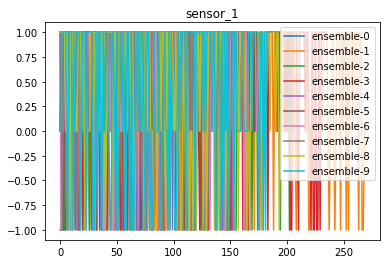

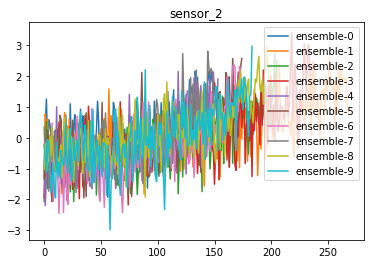

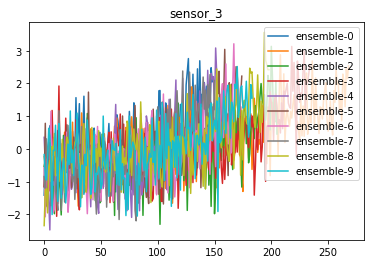

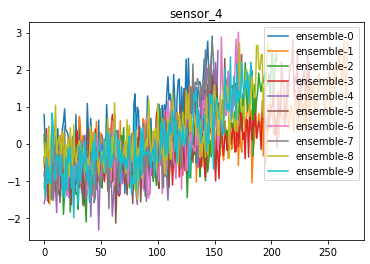

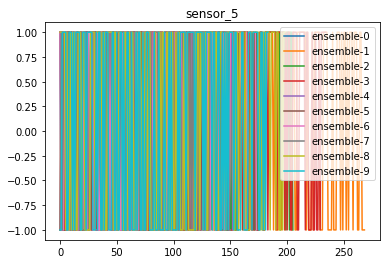

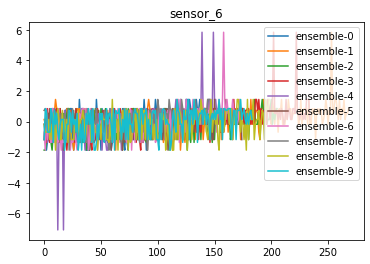

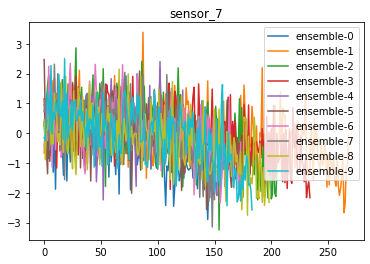

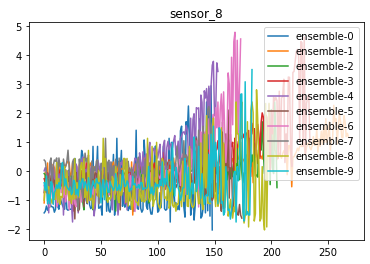

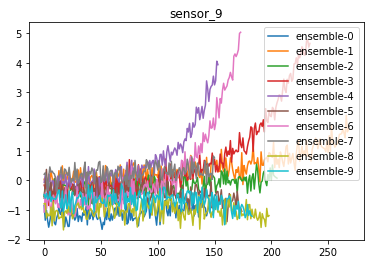

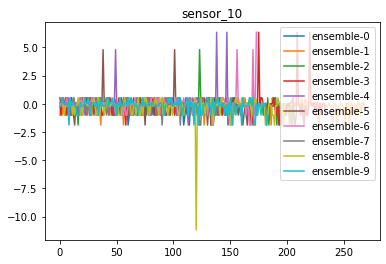

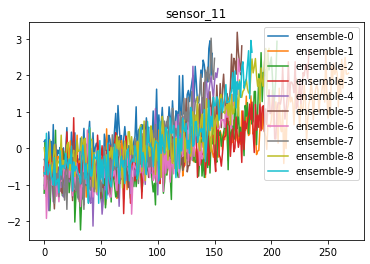

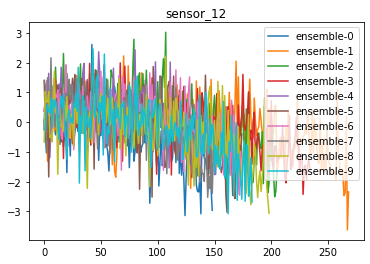

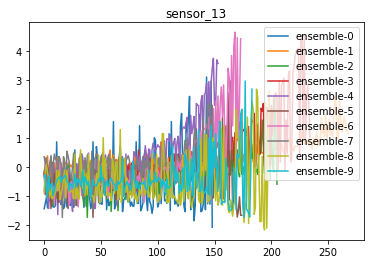

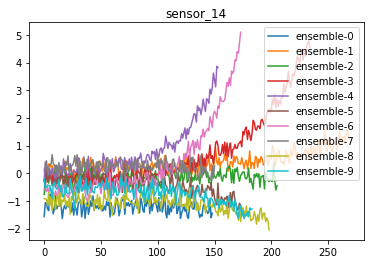

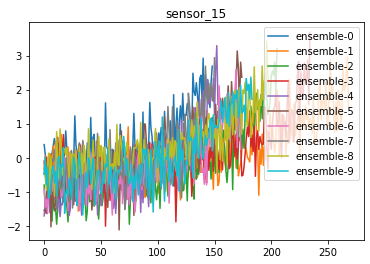

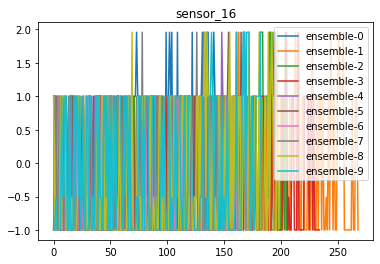

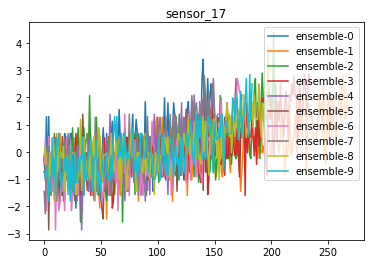

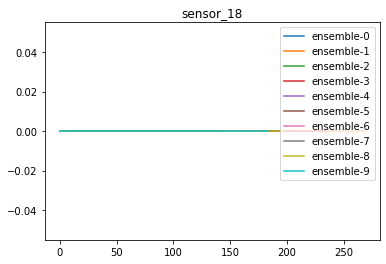

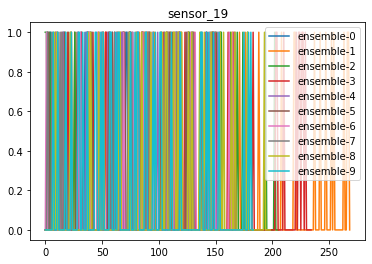

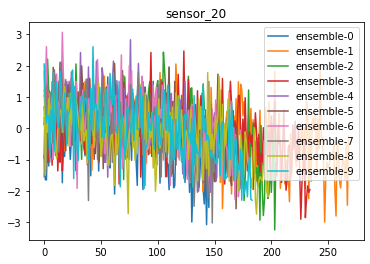

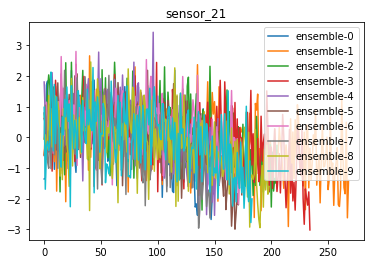

In [ ]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, header_names, normalized_train_data_list)

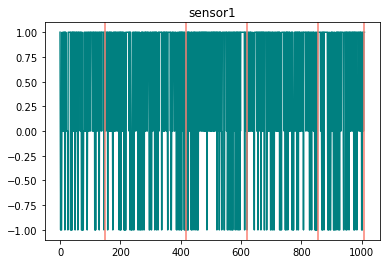

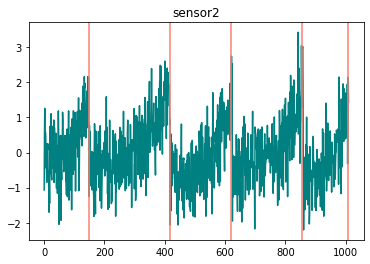

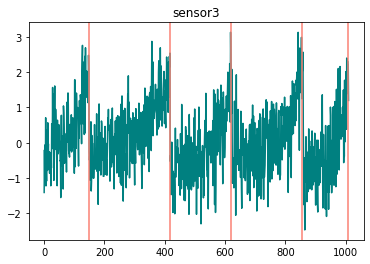

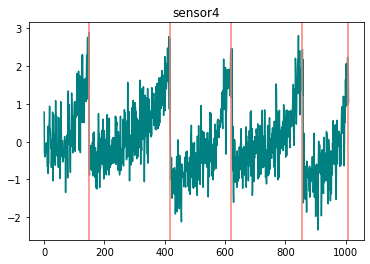

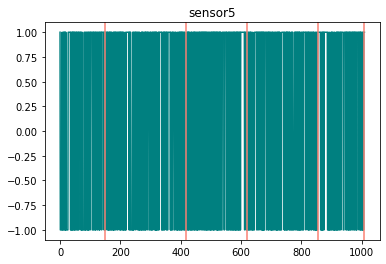

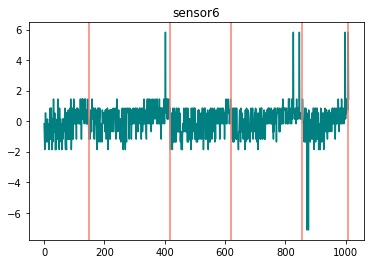

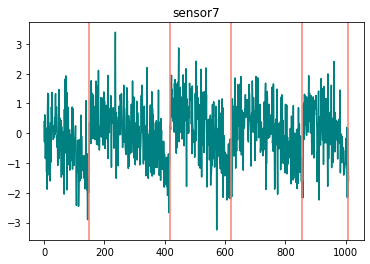

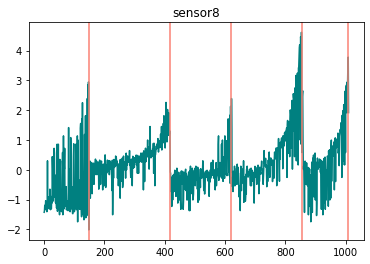

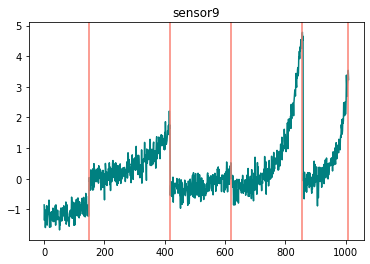

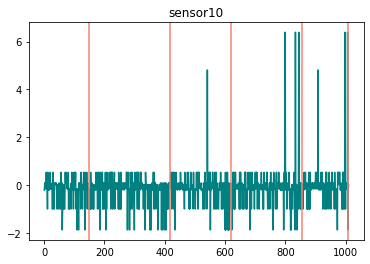

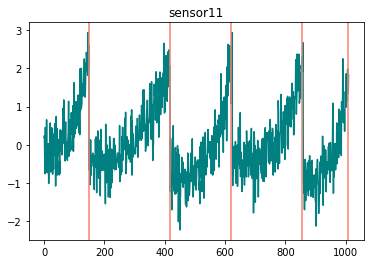

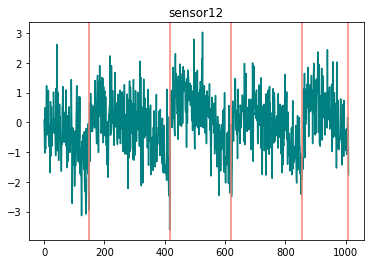

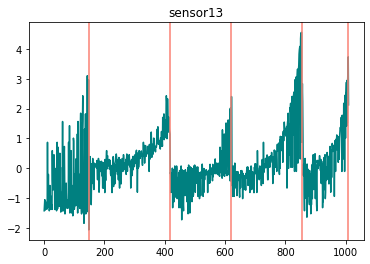

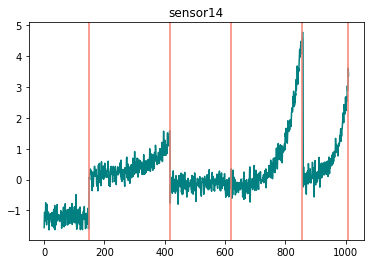

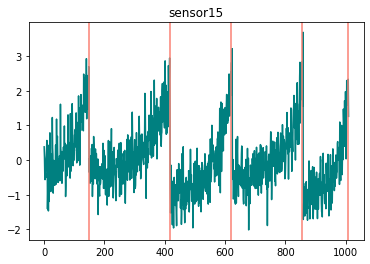

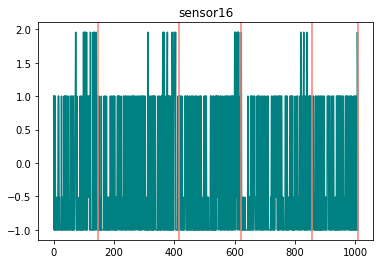

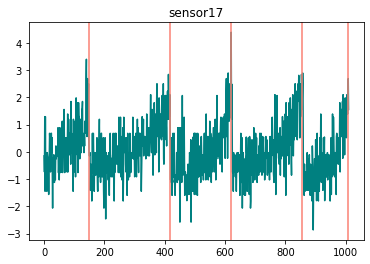

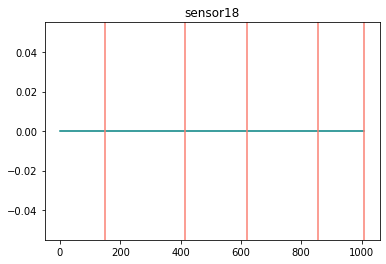

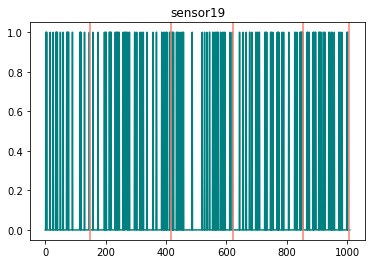

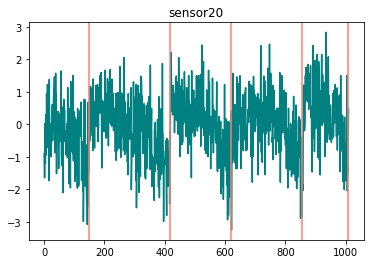

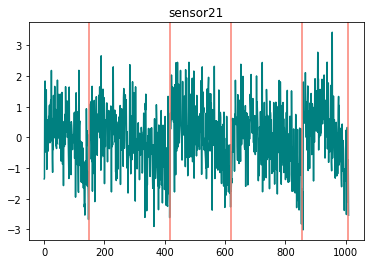

In [ ]:
cycle_plot_func_a(normalized_unwrap_train_data, n_samp=1010)

# Sensor Fusion Section

Trendability Analysis.

In [ ]:
pip install reliability

In [ ]:
# Choose best sensors by fitting a linear degradation model to the data
# Python Reliability library
from reliability.Fitters import Fit_Exponential_2P
data = [15,20,22,26,29]
wb = Fit_Exponential_2P(failures=data)
plt.show() 

Just Use Linear Regression

In [ ]:
from scipy import stats
from scipy.optimize import curve_fit

In [ ]:
np.arange(len(normalized_train_data_list[0]))

In [ ]:
# Regression data list
reg_data_list = []
ensemble_shape_list = []
for l in normalized_train_data_list:
  reg_data = l[:,-21:]
  # print(reg_data.shape)
  ensemble_shape_list.append(reg_data.shape)
  reg_data_list.append(reg_data)
print(len(reg_data_list))
print(len(ensemble_shape_list))

203
203


In [ ]:
sensor_result_list = []
for n_sensor in range(normalized_unwrap_train_data.shape[1]):
  instance_result_list = []
  for n_list in (reg_data_list):
    x=np.arange(len(n_list))
    y=n_list[:,n_sensor] # Y is single sensor data
    res = stats.linregress(x, y)
    instance_result_list.append((res.slope, res.intercept,res.rvalue))
  sensor_result_list.append(instance_result_list)

In [ ]:
sensor_result_list[0][0]

(0.003079992744422275, 0.18818791946308724, 0.18056678829311482)

In [ ]:
# sensor_result_list
average_results_list = []
for loop in sensor_result_list:
  old_mean = np.zeros(3)
  for li, loopm in enumerate(loop):
    new_mean = old_mean + (1/(li+1))*(np.array(loopm)**2 - old_mean)    # Mean squared values
    old_mean = new_mean
  average_results_list.append(new_mean)

In [ ]:
# The avrage R-values: Goodness of fit measure is used to choose the best sensors
# Apparently in this MATLAB model, their criteria for choosing sensors to use is - sensors that have a linear degradation profile
# I personally do not like this method but let's use it. 
average_results_list

[array([0.  , 0.21, 0.  ]),
 array([0.  , 1.23, 0.39]),
 array([0.  , 1.16, 0.37]),
 array([0.  , 1.68, 0.56]),
 array([0.  , 0.06, 0.01]),
 array([0.  , 0.47, 0.14]),
 array([0.  , 0.84, 0.26]),
 array([0.  , 0.73, 0.28]),
 array([0.  , 0.85, 0.43]),
 array([0.  , 0.03, 0.02]),
 array([0.  , 1.85, 0.63]),
 array([0.  , 0.95, 0.29]),
 array([0.  , 0.73, 0.28]),
 array([0.  , 0.7 , 0.48]),
 array([0.  , 1.63, 0.55]),
 array([0.  , 0.19, 0.01]),
 array([0.  , 1.29, 0.41]),
 array([0., 0., 0.]),
 array([0.  , 0.02, 0.  ]),
 array([0.  , 0.74, 0.23]),
 array([0.  , 0.75, 0.23])]

In [ ]:
average_results_list[1][0]

0.00011332939003077349

In [ ]:
# Let's save some lists and variables for next time
checkpoint_sensor_result_list = list_checkpoints('sensor-result-list', sensor_result_list)
checkpoint_saverage_results_list = list_checkpoints('average-results-list', average_results_list)

Finding Most trendable sensors : I wanted to use sensors that had the best fit but MATLAB is all about using sensors with highest slopes: I guess it depends on what we are really trying to find.

In [ ]:
# Collect the r-values in the list and sort in descending order - Choose best 8
r_values_array = np.zeros(len(average_results_list))
for r_i, r_v in enumerate(average_results_list):
  r_values_array[r_i] = r_v[-1]

In [ ]:
sensor_sort = np.argsort(r_values_array)+1

In [ ]:
best_eight = sensor_sort[-10:]

In [ ]:
best_eight

array([13, 12,  3,  2, 17,  9, 14, 15,  4, 11])

Highest slopes - I don't think MATLAB used the average over all instances which shouldn't be.

In [ ]:
# Collect the r-values in the list and sort in descending order - Choose best 8
r_values_array = np.zeros(len(average_results_list))
for r_i, r_v in enumerate(average_results_list):
  r_values_array[r_i] = r_v[0]

In [ ]:
sensor_sort = np.argsort(r_values_array)+1

In [ ]:
best_eight = sensor_sort[-8:]

In [ ]:
sord_best_eight = np.sort(best_eight)

In [ ]:
# Save best eight
checkpoint_best_eight = checkpoints('best-eight', best_eight)

So Our best Sensors Are: 2,3,4,9,11,14,15,17 contrary to MATLAB were theirs were: 2,3,4,7,11,12,15,17 (Off by 11 and 12).


*   This results in comparison to the plots below PLOTS ARE WRONG - REPLOT
*   List item





In [ ]:
# Plots
# Line Plot Function
def plot_func(sensor_header, header_names, data_list):
  for sensor_n in sensor_header:
    for d_ind in range(10):
      plt.plot(data_list[d_ind][:,header_names.index(sensor_n)], label = 'ensemble-'+str(d_ind))
      plt.legend(loc='upper right')
      plt.title(sensor_n)
    plt.show()

# Side-by-side Plot Function: For dataframe (Try to combine both later)
def cycle_plot_func(sensor_header, data, n_samp = 500):
  for sensor_n in sensor_header:
    data[sensor_n][:n_samp].plot(c='teal')
    for m in [148,416,621,855,1008]:
      plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
    plt.title(sensor_n)
    plt.show()

# Side-by-side Plot Function: For array
def cycle_plot_func_a(data, sensor_n_list, n_samp=1010):
  if sensor_n_list is None:
    for n in range(data.shape[1]):
      plt.plot(data[:n_samp,n],c='teal')
      for m in [148,416,621,855,1008]:
        plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
      plt.title('sensor'+str(n+1))
      plt.show()
  else:
      for n in sensor_n_list:
        plt.plot(data[:n_samp,n-1],c='sienna')
        for m in [148,416,621,855,1008]:
          plt.axvline(x = m, color = 'peru', label = 'axvline - full height')
        plt.title('sensor'+str(n))
        plt.show()


In [ ]:
sord_best_eight = np.sort([13, 12,  3,  2, 17,  9, 14, 15,  4, 11])

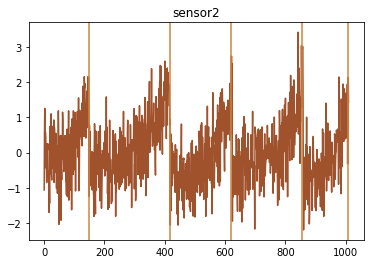

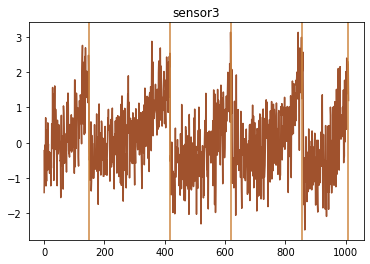

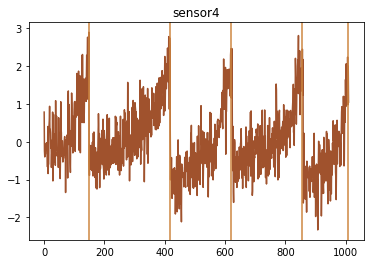

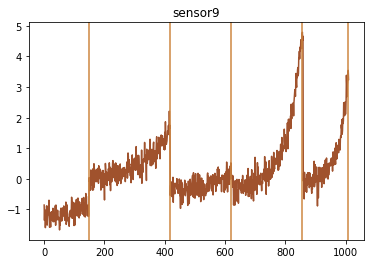

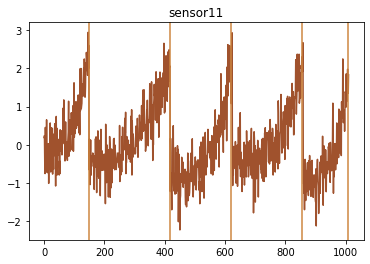

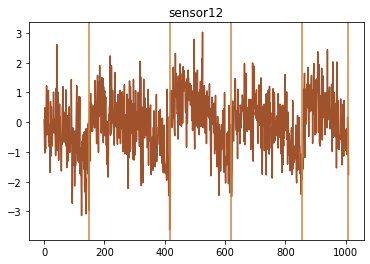

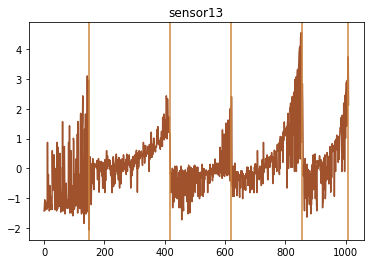

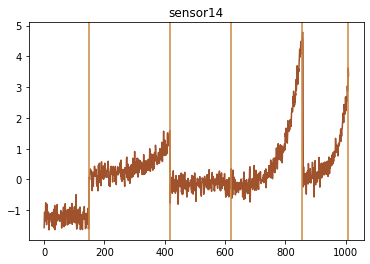

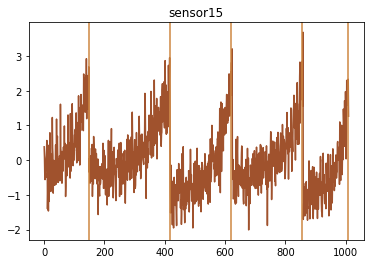

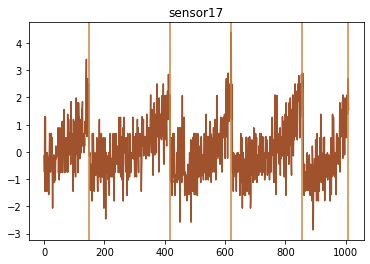

In [ ]:
cycle_plot_func_a(data=normalized_unwrap_train_data, sensor_n_list=sord_best_eight)

In [ ]:
# MATLAB choise of sensors
mt_best_eight = np.array([2,3,4,7,11,12,15,17])
cycle_plot_func_a(normalized_unwrap_train_data, sensor_n_list=mt_best_eight)

In [ ]:
# I am trying to use just sums of weights 
sums_results_list = []
for loop in sensor_result_list:
  sums = np.zeros(3)
  for li, loopm in enumerate(loop):
    sums+=np.array(loopm)**2
  sums_results_list.append(sums)

In [ ]:
# Even with sum-squared, the best metric to choose sensors that fits a linear degradation model best is still the R-values
sums_results_list

[array([ 0.  , 43.49,  0.98]),
 array([  0.02, 248.78,  79.16]),
 array([  0.02, 235.26,  75.44]),
 array([  0.03, 341.6 , 113.48]),
 array([ 0.  , 11.77,  1.15]),
 array([ 0.01, 96.02, 28.76]),
 array([  0.02, 171.38,  52.68]),
 array([  0.02, 148.24,  57.48]),
 array([  0.02, 171.67,  88.14]),
 array([0.  , 6.58, 3.99]),
 array([  0.03, 374.95, 128.61]),
 array([  0.02, 191.87,  59.05]),
 array([  0.02, 148.63,  57.75]),
 array([  0.02, 143.03,  97.42]),
 array([  0.03, 331.13, 111.04]),
 array([ 0.  , 38.28,  3.03]),
 array([  0.02, 260.97,  83.64]),
 array([0., 0., 0.]),
 array([0.  , 4.8 , 0.88]),
 array([  0.01, 150.99,  46.43]),
 array([  0.01, 152.31,  46.09])]

Health Index Mapping to Sensor Values - Linear Regression with RidgeCV.

*   We will be using sklearn RidgeCv algorithm to reduce variance, get better validation accuracy and generalization - Because we are working with time series data, and there are autocorrelations btw observations that are near in time and the samples are not IID, Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model.
*   CROSS VALIDATION REASONING: However, by partitioning the available data into sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

*   First let's see how sklearn Time Series Split function will split this data.
*   Because I have ensemble data, I will try using cv_score method instead, instantiate the model multiple times with different alpha's, train on my train set and validate on a few validation sets.





In [ ]:
# Load normalized_train_data_list and normalized_unwrap_train_data
from google.colab import files
uploaded = files.upload()

Saving normalized-unwrap-val-data.npy to normalized-unwrap-val-data.npy
Saving normalized-unwrap-val-fdata.npy to normalized-unwrap-val-fdata.npy
Saving normalized-val-data-list.npy to normalized-val-data-list.npy


In [ ]:
# Load these datasets
# data_list = np.load('/content/data-list.npy', allow_pickle=True)
normalized_train_data_list = np.load('/content/normalized-train-data-list.npy', allow_pickle=True)
normalized_unwrap_train_data = np.load('/content/normalized-unwrap-train-data (1).npy')
normalized_unwrap_train_fdata = np.load('/content/normalized-unwrap-train-fdata (1).npy')
# best_eight=np.load('/content/best-eight.npy')

In [ ]:
# Load Validation datasets
normalized_val_data_list = np.load('/content/normalized-val-data-list.npy', allow_pickle=True)
normalized_unwrap_val_data = np.load('/content/normalized-unwrap-val-data.npy')
normalized_unwrap_val_fdata = np.load('/content/normalized-unwrap-val-fdata.npy')

In [ ]:
best_eight=np.load('/content/best-eight.npy')

In [ ]:
normalized_train_data_list[1].shape

(269, 26)

In [ ]:
# Yeah, this is how it works but we have ensemble data (Groups)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
for train, test in tscv.split(normalized_train_data_list[1]):
  print("%s %s" % (train, test))

So I will go ahead and use cv_score to find best alpha rather than use RidgeCV because it gives me more control over my data and I will not shuffle the data - Let's see how it behaves.

In [ ]:
# Prepare X-train and y-train just as we did previously
# For x-train, just remove the best 8 sensor data from the array:
sorted_eight = np.sort(best_eight)
x_train = normalized_unwrap_train_data[:,sorted_eight-1]
print(x_train.shape)

(41456, 8)


Construct Health Indicators - The sensor fusion method seems a little basic but it is not, it uses the survival duration of each machine/instance to group the health condition, so even if it takes you longer to die, you still pass through all these stages of failure and to be able to compare you to another machine which is what I am really trying to do, I need this metric (level of degradation) irrespective of the time you reach it.

*   Then linear regression was used for prediction: Linear regression was not used to fuse the data together, without linear regression, we still have the sensor fusion but because we would have instances where the survival duration is unknown or instances that are right censored, we use a regressor to learn a mapping from the sensor values to the health index or fused values.
*   Don't mix the feature extraction method with the sensor fusion method or the linar regression method. They are use a linear model or mapping and it might look like they are trying to do the same thing but they are not. The only assumption or concrete assumption about the sensor fusion method chosen is that the machines/instances have constant failure rates for every instance (Like a light bulb), this cannot be proven BUT this assumption shouldn't or wouldn't result in a problem or misestimation because it is not directly involved in the RUL estimation, it basically places the machine instances on a level scale for comparison.

*   And this is why I think this sensor fusion method is good enough, using variational autoencoders might be an overkill. What we really need is a basis for comaprison and we formed one ourselves (The way 1kg = 1000gram) and every other thing is measured on this basis.
*   So I think what we should focus more upon is the degradation profile characteristics used to estimate RUL, the similarity measure method used, and the mapping of the sensor values to the health index (Maybe try LSTM for better results).  - Test this theory when you use VAE and write paper.





In [ ]:
health_index_list = []
for instance in normalized_train_data_list:
  rul = instance.shape[0] - instance[:,1]
  health_index = rul/max(rul)
  health_index_list.append(health_index)

In [ ]:
health_index_list[1].shape

(269,)

In [ ]:
import itertools
# Use itertools in python
health_index_unwrap = list(itertools.chain(*health_index_list))

# Some Checks
print(len(health_index_unwrap) == normalized_unwrap_train_fdata.shape[0])

# y_train
y_train = np.array(health_index_unwrap)

# More checks
print(y_train.shape, x_train.shape[0])

True
(41456,) 41456


In [ ]:
checkpoint_health_index_unwrap = checkpoints('health-index-unwrap', np.array(health_index_unwrap))

Prepare Validation Data

In [ ]:
# Prepare X-val and y-val just as we did previously
# For x-val, just remove the best 8 sensor data from the array:
x_val = normalized_unwrap_val_data[:,sorted_eight-1]
print(x_val.shape)

(12303, 8)


In [ ]:
health_index_list = []
for instance in normalized_val_data_list:
  rul = instance.shape[0] - instance[:,1]
  health_index = rul/max(rul)
  health_index_list.append(health_index)

In [ ]:
len(health_index_list)

60

In [ ]:
import itertools
# Use itertools in python
health_index_unwrap = list(itertools.chain(*health_index_list))

# Some Checks
print(len(health_index_unwrap) == normalized_unwrap_val_fdata.shape[0])

# y_train
y_val = np.array(health_index_unwrap)

# More checks
print(y_val.shape, x_val.shape[0])

True
(12303,) 12303


In [ ]:
checkpoint_health_index_val_unwrap = checkpoints('health-index-val-unwrap', np.array(health_index_unwrap))

Let's save some variables

In [ ]:
# Save x-train, y-train, x-val, y-val
checkpoint_x_train = checkpoints('x-train', x_train)
checkpoint_y_train = checkpoints('y-train', y_train)
checkpoint_x_val = checkpoints('x-val', x_val)
checkpoint_y_val = checkpoints('y-val', y_val)

Now Let's train

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, cross_val_score
ps = PredefinedSplit(x_val[5000])

models = {"alpha 0.001": Ridge(alpha=0.001),
          "alpha 0.003": Ridge(alpha=0.003),
          "alpha 0.01": Ridge(alpha=0.01),
          "alpha 0.03": Ridge(alpha=0.03),
          "alpha 0.1": Ridge(alpha=0.1),
          "alpha 0.3": Ridge(alpha=0.3),
          "alpha 0.5": Ridge(alpha=0.5)}

results = []
for model in models.values():
  model.fit(x_train,y_train)
  result = model.score(x_val[:5000], y_val[:5000])
  results.append(result)


In [ ]:
results

[0.6462992104749559,
 0.6462992111123256,
 0.6462992133431038,
 0.6462992197166222,
 0.6462992420223784,
 0.646299305739753,
 0.646299369437344]

In [ ]:
# Now let's train
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.03)
ridge.fit(x_train,y_train)
result = ridge.score(x_val[:5000],y_val[:5000])

In [ ]:
# Let's see how sklearn ridgeCV behaves
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train, y_train)
clf.score(x_val[:5000], y_val[:5000])


0.6462995285944415

In [ ]:
clf.get_params()

{'alpha_per_target': False,
 'alphas': [0.001, 0.01, 0.1, 1],
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_values': False}

In [ ]:
y_pred = clf.predict(x_val)

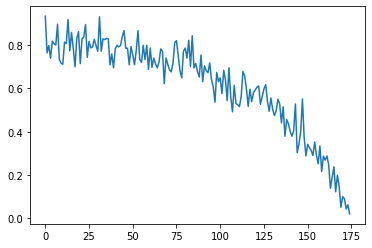

In [ ]:
plt.plot(y_pred[:175]);

Observation: Linear regression is not suitable for this kind of data but since what we need it for isn't so not as a prediction algorithm, rather as a fusion technique, I think we can use it.

RUL ESTIMATION.

*   ARMA Model - Autoregressive Moving Average (It is saying, the RUL for this timestep is a function of the RUL from last timestep). We are leveraging available information, we could have used the predictive power of ARMA model to predict the RUL for next timestep BUT guess what, we do not know the RUL of the test data because it has not failed BUT we know the RUL of the train data, so we find the 50 closest instances (from train set @ current timestep - we can say they have similar degradation profiles), use ARMA on those to find the parameters (In this statistical case, we are not using the info from a sample to describe the population (not literally), but we are using available data to predict unavailable (MACHINE LEARNING APPROACH).  
* So here is what we do - We find the health index (The health index represents a lower dimensional representation (preferablt 1D) of the sensor data and this is why unsupervised learning methods are used here. Unsupervised learning need no labels, they find a lower dimensional representation of data......
Then after we get a good health index which we can then apply a degradation model (which gets updated continuosly to learn the degradation profile of the data and keeps adjuating it parameters with new info and discarding priors), with the degradation model, I think a new health index or atleast a metric for similarity would be found and used to get the machines/engines with similar degradtion profiles. THE GOAL IS TO GET SAMPLES THAT HAVE SIMILAR DEGRADATION PROFILES AS THE VALIDATION DATA.
 (This is what I do not know how to find.) Which might be where ARIMA makes sense, where d parameters of all the engines/instances is updated at intervals till the current time step..          
*     I say I use unsupervised learning for sensor fusion, I remove the need for a health index that has to be predicted after assumed. Fuse 8D to 1D (say it is linearly degrading with time), curve fit, use as similarity measure and 
And the RUL for last time steps of the train dataset is known
*   Estimated RUL is the median of the 50 nearest neighbours RUL (Fit a probability distribution to their RULs, most likely a nor mdistribution and find the mean/median). The RULs (of all 50 nearest instances using the similarity measure with reference to the health index) however were estimated using the ARMA model.


*   Finally, while I am yet to read up on how to use degradation models, I think the health index used in MATLAb is a pretty good basis for comparison without a need for degradation data or profile. So I will just do it.  






In [ ]:
# RUL Function - Give it an array of full data containing column 1 (Time)
def rul_func(data):
  rul = data.shape[0] - data[:,1]
  return rul

In [ ]:
rul_func(normalized_val_data_list[1])

In [ ]:
# Take a single Validation ensemble
print(normalized_val_data_list[1].shape, health_index_list[1].shape)
ens_health_indices = y_val[:normalized_val_data_list[1].shape[0]]
ens_ruls = rul_func(normalized_val_data_list[1])
print(ens_health_indices.shape, ens_ruls.shape)
ens_HI_RUL = (np.array([ens_health_indices,ens_ruls])).T
print(ens_HI_RUL.shape)

(197, 26) (197,)
(197,) (197,)
(197, 2)


In [ ]:
import math
print(math.ceil(ens_HI_RUL.shape[0]/2))
ens_HI_RUL[math.ceil(ens_HI_RUL.shape[0]/2)]

99


array([ 0.48, 97.  ])

In [ ]:
# Form an ens_HI_RUL array for train data as well (Pass arrays not lists, data = full data array, y_data = health indices)
def ens_HI_RUL_func(data, y_data):
  # print(data.shape, y_data.shape)
  ens_health_indices = y_data[:data.shape[0]]
  ens_ruls = rul_func(data)
  # print(ens_health_indices.shape, ens_ruls.shape)
  ens_HI_RUL = (np.array([ens_health_indices,ens_ruls])).T
  print(ens_HI_RUL.shape)
  return ens_HI_RUL


In [ ]:
# Now let's create a list of ens_HI_RUL for all ensemble train and validation data
ens_train_list = []
start_point = 0
for ens in normalized_train_data_list:
  end_point = ens.shape[0]
  y_data = y_train[start_point:(start_point+end_point)]
  ens_train_list.append(ens_HI_RUL_func(ens, y_data=y_data))
  start_point = end_point

In [ ]:
# Verification
shape_list = []
for count in normalized_train_data_list:
  shape_list.append(count.shape[0])

e_shape_list = []
for e_count in ens_train_list:
  e_shape_list.append(e_count.shape[0])

np.array(shape_list) == np.array(e_shape_list)

In [ ]:
shape_list

In [ ]:
# Some New Checkpoints


RUL Estimation with MATLAB PredictRUL function.

In [ ]:
!apt install octave

In [ ]:
%%writefile test.m
x=4
y=5
display(4+5)

Writing test.m


In [ ]:
# -W: No window system
!octave -W test.m

x =  4
y =  5
 9


In [ ]:
# RUL/Model function
%%writefile model.m
mdl = residualSimilarityModel(...
    'Method', 'poly2',...
    'Distance', 'absolute',...
    'NumNearestNeighbors', 50,...
    'Standardize', 1);

fit(mdl, trainDataFused);

validationDataTmp50 = 

PCA TEST

In [ ]:
pca_data_1 = raw_train_df.values[:149]

In [ ]:
pca_data_2 = raw_train_df.values[149:300] 

In [ ]:
pca_data_2.shape

(151, 26)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from scipy.linalg import norm
# Reconstruction error - MSE
def reconsruction_error(original, reconstructed):
  return norm((original-reconstructed))

In [ ]:
# Sklearn PCA automaticall does mean normalization but not standardization (i.e doesn't divide by std - determine if this is required for your dataset yourself)
pca = PCA(n_components=5)
pca.fit(pca_data_1)
orig_transform = pca.transform(pca_data_1) # Transform to 5 dimensions
orig_reconstruction = pca.inverse_transform(orig_transform)  # Transform back to original shape 
error_1 = reconsruction_error(original=pca_data_1, reconstructed=orig_reconstruction)

In [ ]:
error_1

79.17613355225453

In [ ]:
out_data_transform = pca.transform(pca_data_2) # Use the n_components to transform out of training distribution data
out_data_reconstruction = pca.inverse_transform(out_data_transform)  # Transform back to original shape 
error_2 = reconsruction_error(original=pca_data_2, reconstructed=out_data_reconstruction)

In [ ]:
error_2

276.24263899250354

In [ ]:
# Reconstruction error very large
error_2 - error_1

197.06650544024902

 Within distribution test - It can be observed that in distribution error is not so huge.

In [ ]:
# Sklearn PCA automaticall does mean normalization but not standardization (i.e doesn't divide by std - determine if this is required for your dataset yourself)
pca = PCA(n_components=5)
pca.fit(pca_data_1[:100])
orig_transform = pca.transform(pca_data_1[:100]) # Transform to 5 dimensions
orig_reconstruction = pca.inverse_transform(orig_transform)  # Transform back to original shape 
error_1 = reconsruction_error(original=pca_data_1[:100], reconstructed=orig_reconstruction)

In [ ]:
error_1

56.89219127430088

In [ ]:
out_data_transform = pca.transform(pca_data_1[100:]) # Use the n_components to transform out of training distribution data
out_data_reconstruction = pca.inverse_transform(out_data_transform)  # Transform back to original shape 
error_2 = reconsruction_error(original=pca_data_1[100:], reconstructed=out_data_reconstruction)

In [ ]:
error_2

75.82959281797496

In [ ]:
# Reconstruction error very large
error_2 - error_1

18.937401543674078

In [ ]:
# K components was chosen such that 99% of the variance was reduced
print(pca.explained_variance_ratio_.round(2),pca.explained_variance_.round(2))

[0.89 0.11 0.   0.   0.  ] [2.3931603e+05 2.9171730e+04 8.3424000e+02 4.9618000e+02 1.8503000e+02]


In [ ]:
# Load dataset
# Some exloratory analysis - Check for Monotonicity
# Divide dataset by machines
# Split train-val data (208,208:260)
# Working Regime clustering
# Trendability Analysis - Fit a linear degradation model (Average slope across all 208 instances of each sensor)
# Select 8 most trended sensors - Y 8?
# Construct health Indicator for all 208 instances - i.e Create degradation profile for each component
# Train a linear regression model - Evaluate on val set, note that test data points wouldn't have a failure data in them and we would like to predict the health index
# at any given time (LSTM) would be a better estimator 
# Plot train and validation set health learnt indicators for all instances
# Build similarity RUL model - (Try my method and MATLAB method)
# Performance Evaluation

# FUSE - FIT - ESTIMATE RUL - EVALUATE
# NOTES: Now that I see what they are doing, I think their sensor fusion technique might be an overkill but it is still good.
# Rather than fit a linear/statistical model - Why not use a neural network here? The answer is you don't need a label